In [1]:
from tensorflow import keras

## 로이터 데이터셋

1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터셋을 사용하겠다. 이 데이터셋은 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋이다. 46개의 토픽이 있으며 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있다.

In [2]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [3]:
print(len(train_data), len(test_data))

8982 2246


In [4]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


## 데이터 준비

In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

레이블을 벡터로 바꾸기 위해 원핫인코딩을 사용하자

In [6]:
def to_one_het(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
        
    return results

one_hot_train_labels = to_one_het(train_labels)
one_hot_test_labels = to_one_het(test_labels)

케라스에는 이를 위한 내장 함수가 있다.

In [7]:
from tensorflow.keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 모델 구성

이전의 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많을 것 같다. 이런 이유로 좀 더 규모가 큰 층을 사용하겠다.

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

2022-05-17 13:48:58.878345: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 13:48:59.500004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21332 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:06:00.0, compute capability: 7.5


In [9]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 훈련 검증

훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트로 사용하겠다.

In [10]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

이제 20번의 에폭으로 모델을 훈련시키자.

In [11]:
history = model.fit(partial_x_train,
                   partial_y_train, epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

2022-05-17 13:49:09.703364: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
16/16 [==============================] - 2s 46ms/step - loss: 2.6512 - accuracy: 0.5065 - val_loss: 1.7808 - val_accuracy: 0.6350
Epoch 2/20
16/16 [==============================] - 1s 38ms/step - loss: 1.4470 - accuracy: 0.6992 - val_loss: 1.3189 - val_accuracy: 0.7040
Epoch 3/20
16/16 [==============================] - 0s 25ms/step - loss: 1.0546 - accuracy: 0.7761 - val_loss: 1.1188 - val_accuracy: 0.7550
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8289 - accuracy: 0.8221 - val_loss: 1.0198 - val_accuracy: 0.7850
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6578 - accuracy: 0.8641 - val_loss: 0.9651 - val_accuracy: 0.7870
Epoch 6/20
16/16 [==============================] - 0s 13ms/step - loss: 0.5209 - accuracy: 0.8941 - val_loss: 0.9012 - val_accuracy: 0.7970
Epoch 7/20
16/16 [==============================] - 0s 12ms/step - loss: 0.4183 - accuracy: 0.9153 - val_loss: 0.8851 - val_accuracy: 0.8000
Epoch 8/20
16

In [12]:
import matplotlib.pyplot as plt

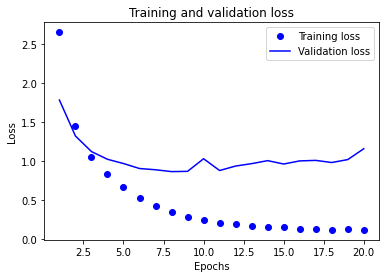

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

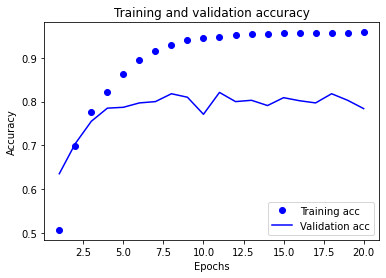

In [14]:
plt.clf()   # 그래프를 초기화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 모델은 9번째 에폭 이후에 과대적합이 시작된다. 9번의 에폭으로 새로운 모델을 훈련하고 테스트 세트에서 평가하겠다.

In [15]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 28ms/step - loss: 2.6783 - accuracy: 0.5193 - val_loss: 1.7936 - val_accuracy: 0.6460
Epoch 2/9
16/16 [==============================] - 0s 13ms/step - loss: 1.4760 - accuracy: 0.7066 - val_loss: 1.3391 - val_accuracy: 0.7180
Epoch 3/9
16/16 [==============================] - 0s 14ms/step - loss: 1.0923 - accuracy: 0.7720 - val_loss: 1.1560 - val_accuracy: 0.7490
Epoch 4/9
16/16 [==============================] - 0s 14ms/step - loss: 0.8652 - accuracy: 0.8137 - val_loss: 1.0512 - val_accuracy: 0.7740
Epoch 5/9
16/16 [==============================] - 0s 21ms/step - loss: 0.6879 - accuracy: 0.8550 - val_loss: 0.9797 - val_accuracy: 0.7850
Epoch 6/9
16/16 [==============================] - 1s 37ms/step - loss: 0.5480 - accuracy: 0.8847 - val_loss: 0.9328 - val_accuracy: 0.8000
Epoch 7/9
16/16 [==============================] - 0s 16ms/step - loss: 0.4357 - accuracy: 0.9087 - val_loss: 0.8977 - val_accuracy: 0.8140
Epoch 8/9
16/16 [===

In [16]:
results

[0.9570998549461365, 0.7889581322669983]

## 새로운 데이터에 대해 예측하기

모델 인스턴스의 predict 메서드는 46개 토픽에 대한 확률 분포를 반환한다.

In [19]:
predictions = model.predict(x_test)

In [21]:
predictions.shape

(2246, 46)

In [22]:
np.argmax(predictions[0])

3